In [1]:
import tensorflow as tf

In [4]:
import numpy as np

subject = '14'
# start_path = f'/Volumes/bci_pi_shared/home/bcipi/DEV/bci_project/src/eye_state_testing/S{subject}/'
start_path = f"../DataSet_and_Model/S{subject}/" # linux and mac
# Load the EEG data from the files
file_X = f'{start_path}X_raw_S{subject}.npy'

file_y = f'{start_path}Y_S{subject}.npy'

X_preprocessing = np.load(file_X)
y_preprocessing = np.load(file_y)

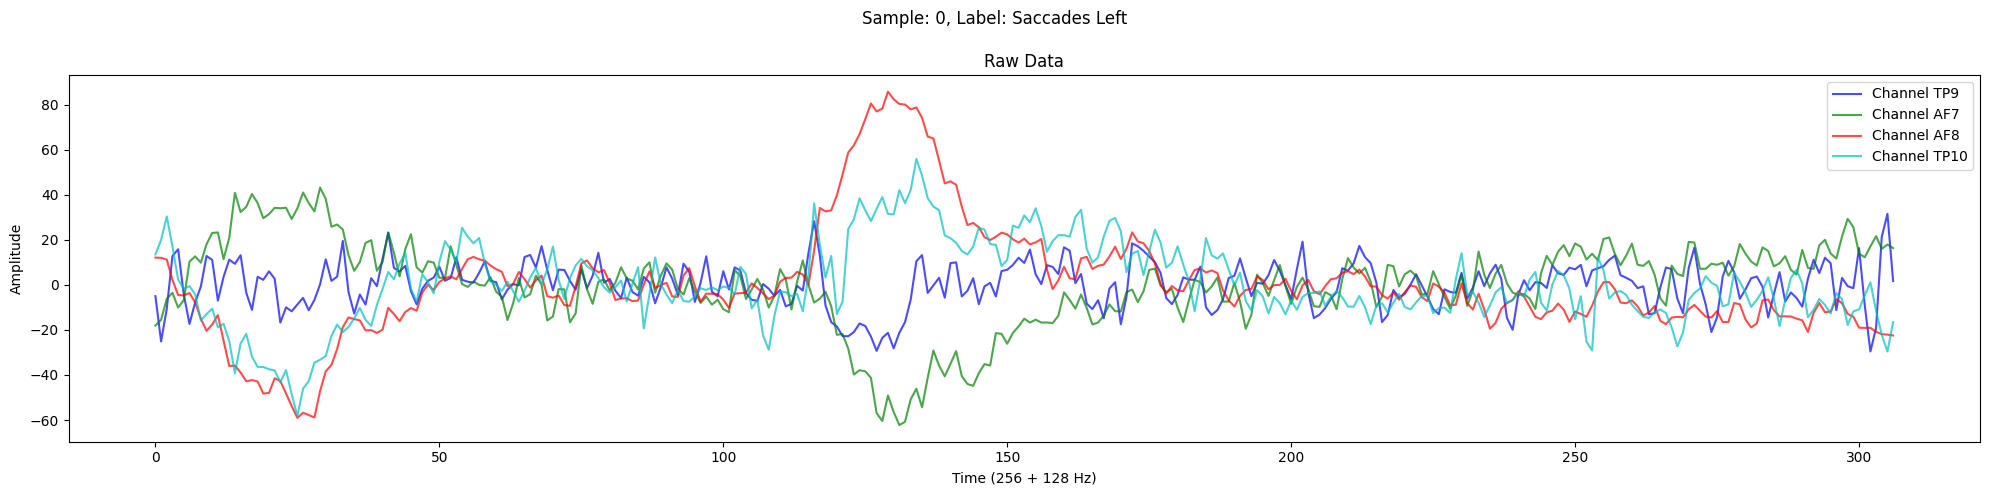

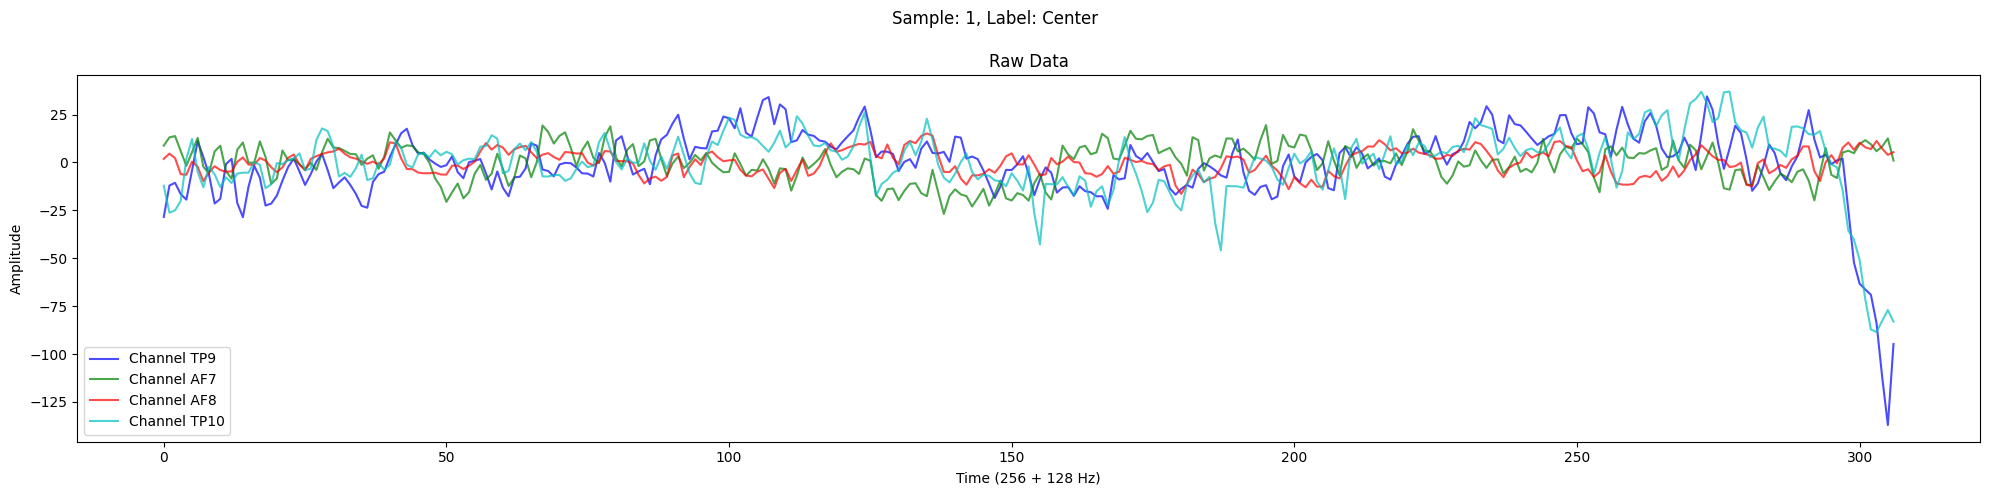

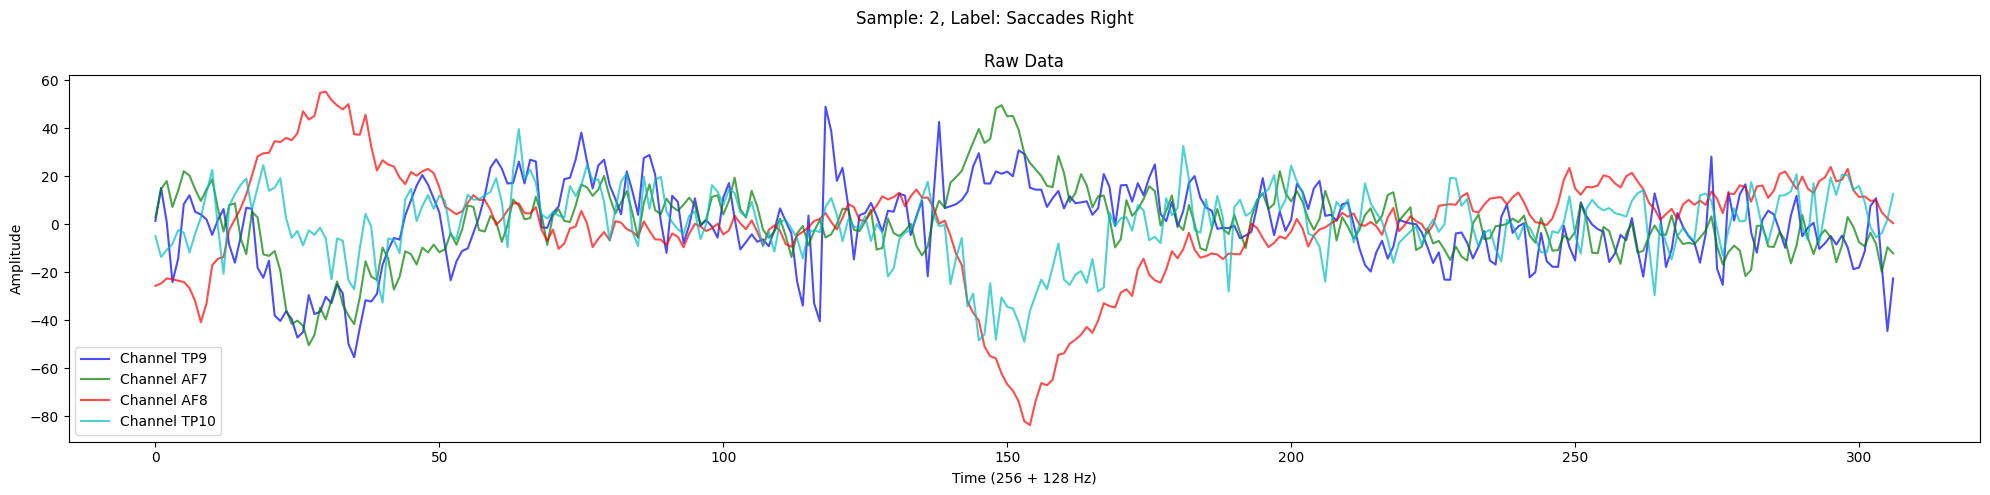

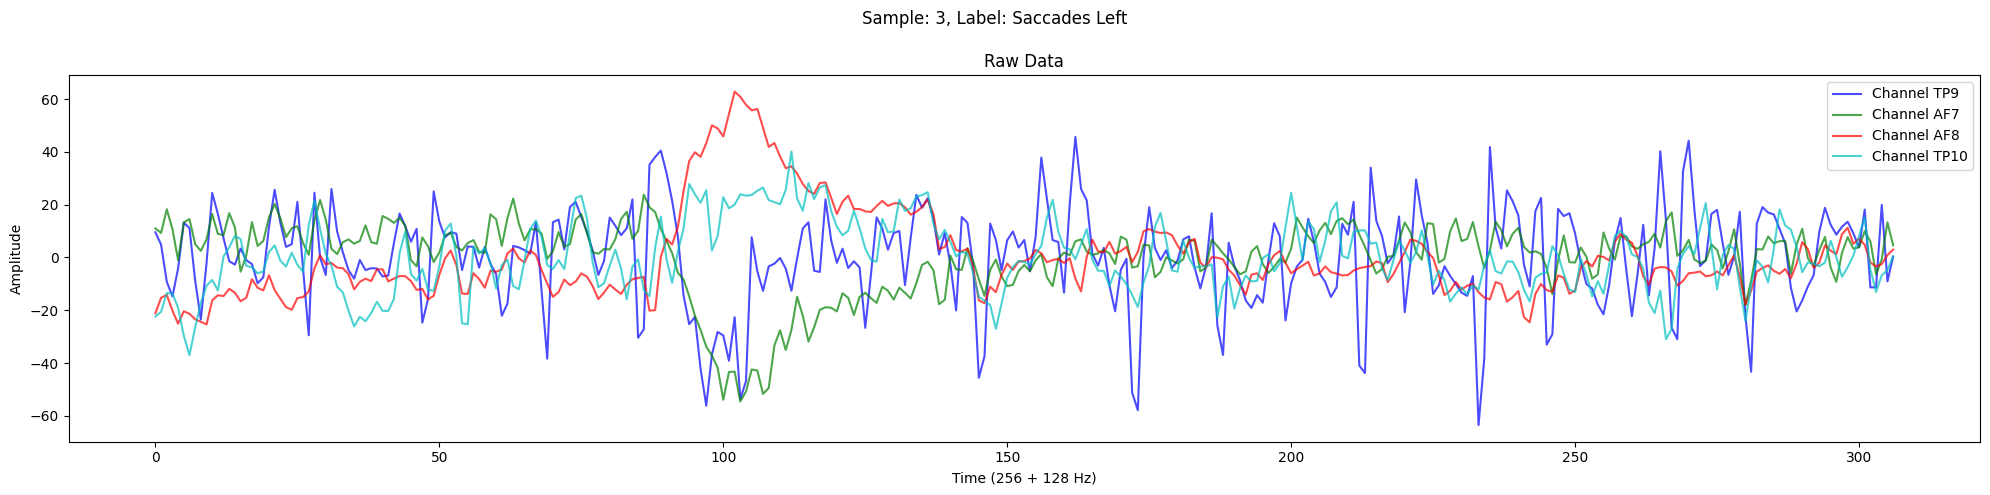

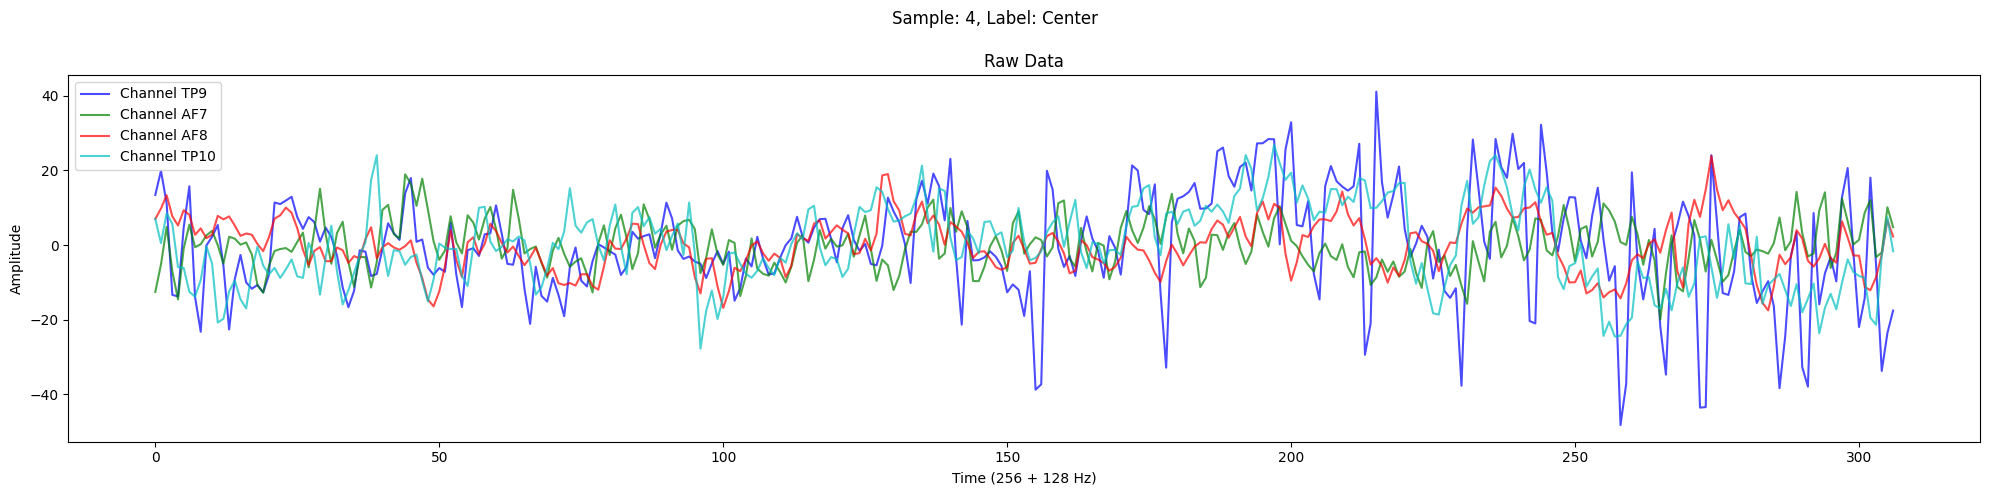

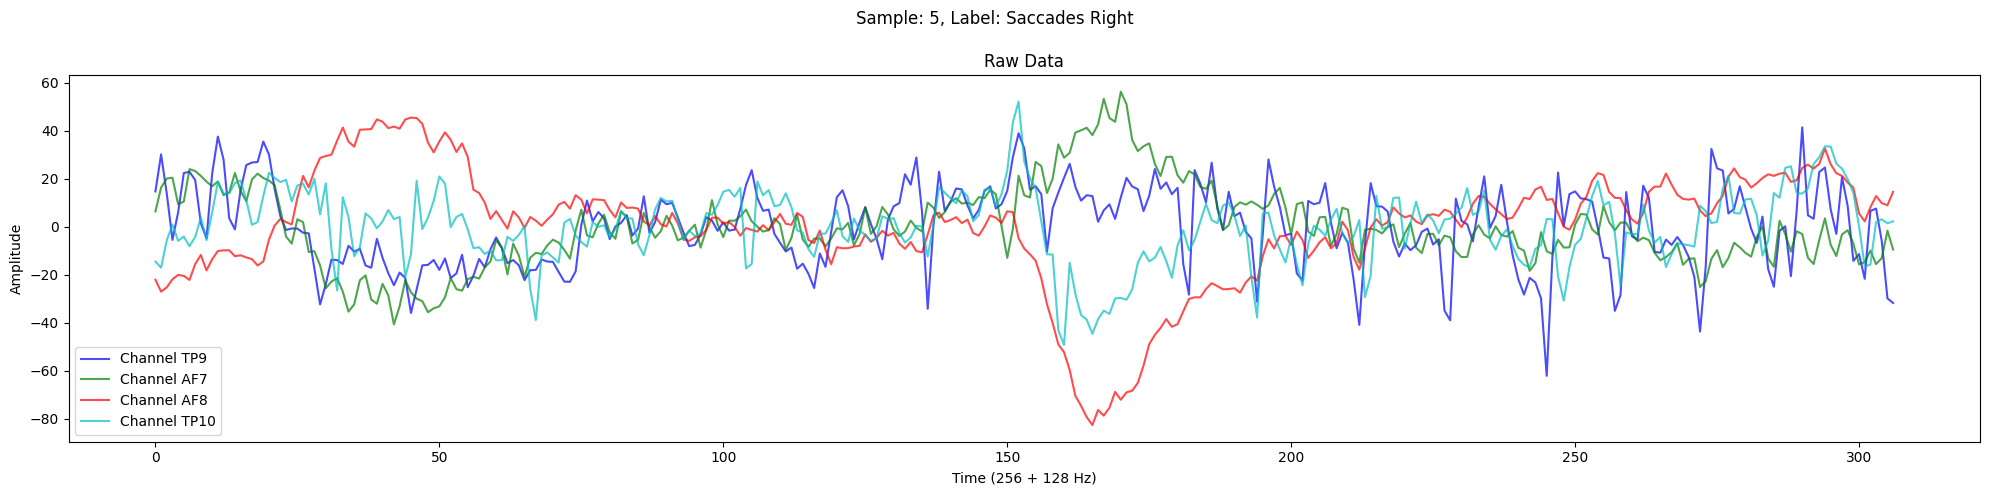

In [5]:
import matplotlib.pyplot as plt

index = 0
n_show = 0

# ชื่อช่วงความถี่
# frequency_bands = ['Raw', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
frequency_bands = ['Raw']

# สีสำหรับแต่ละช่องสัญญาณ (ปรับตามความต้องการ)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan']
channel = ['TP9', 'AF7', 'AF8', 'TP10']
# channel = ['AF7', 'AF8']

while index < y_preprocessing.shape[0]:
    if n_show <= 5:
        fig, ax = plt.subplots(figsize=(20, 5))  # ใช้ subplot เดียวสำหรับข้อมูล raw
        fig.suptitle(f"Sample: {index}, Label: {y_preprocessing[index]}")

        for j in range(4):  # ลูปผ่านช่องสัญญาณ 4 ช่อง
            ax.plot(X_preprocessing[index, :, j], alpha=0.7, color=colors[j % len(colors)], label=f'Channel {channel[j % 4]}')

        ax.set_title(f'Raw Data')
        ax.set_xlabel('Time (256 + 128 Hz)')
        ax.set_ylabel('Amplitude')
        ax.legend()

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # adjust the top spacing to make room for the main title
        plt.show()
        print(f"{100*'=='}")
        n_show += 1
    index += 1

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd

label_encoder = LabelEncoder()
encoded_data = label_encoder.fit_transform(y_preprocessing)

one_encoded_data = to_categorical(encoded_data, num_classes=3)  # แปลงเป็น one-hot encoding
# ดูค่าที่แปลงแล้ว
# print("Encoded values:", encoded_data)
# print("One Encoded values:", one_encoded_data)
# สร้างตารางเพื่อดูค่าที่แปลงแล้วและค่าที่แท้จริง
label_mapping = pd.DataFrame({'Original Value': label_encoder.classes_, 'Encoded Value': range(len(label_encoder.classes_))})
print(label_mapping)

   Original Value  Encoded Value
0          Center              0
1   Saccades Left              1
2  Saccades Right              2


In [9]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.utils import plot_model

# Step 1: Build the EEG classification model
def build_eeg_classification_model(input_shape, num_classes):
    Input_layer = Input(shape=input_shape)
    Conv1D_layer = Conv1D(filters=128, kernel_size=1, activation='relu')(Input_layer)
    LSTM_layer = LSTM(128, dropout=0.2, recurrent_regularizer=l2(0.001))(Conv1D_layer)
    Output_layer = Dense(num_classes, activation='softmax')(LSTM_layer)

    model = Model(inputs=Input_layer, outputs=Output_layer)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessing, one_encoded_data, test_size=0.2, random_state=42)

# Step 3: K-fold cross validation and store all models
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_models = []  # List to store all models from each fold
history_list = []  # List to store training history

for fold, (train_index, val_index) in enumerate(kf.split(X_train), start=1):
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

    model = build_eeg_classification_model(input_shape=(X_fold_train.shape[1], X_fold_train.shape[2]), num_classes=3)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    history = model.fit(
        X_fold_train, y_fold_train, epochs=300, batch_size=4,
        validation_data=(X_fold_val, y_fold_val), callbacks=[early_stopping], verbose=1
    )

    history_list.append(history.history)
    all_models.append(model)  # Save the model for this fold

# Step 4: Evaluate all models on the test set and choose the best model
best_test_accuracy = 0
best_test_model = None

for i, model in enumerate(all_models):
    y_test_pred = model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_test, axis=1)

    test_accuracy = np.mean(y_test_pred_classes == y_test_true_classes)
    print(f"Model {i+1} - Test accuracy: {test_accuracy:.4f}")

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_test_model = model

# Step 5: Save the best model from the test set evaluation
folder_name = os.path.join(start_path, f"model_results_S{subject}")
os.makedirs(folder_name, exist_ok=True)

# Save the best model
model_filename = os.path.join(folder_name, "eeg_model.h5")
best_test_model.save(model_filename)

# Confusion matrix for the best test model
y_test_pred = best_test_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
cm_filename = os.path.join(folder_name, "confusion_matrix.png")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping["Original Value"], yticklabels=label_mapping["Original Value"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.savefig(cm_filename)
plt.close()

# Classification report
report_filename = os.path.join(folder_name, "classification_report.txt")
report = classification_report(y_test_true_classes, y_test_pred_classes, target_names=label_mapping["Original Value"], digits=4)
with open(report_filename, "w") as f:
    f.write(report)

# Learning curve for the best model
learning_curve_filename = os.path.join(folder_name, "learning_curve.png")
plt.plot(history_list[all_models.index(best_test_model)]['accuracy'])
plt.plot(history_list[all_models.index(best_test_model)]['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(learning_curve_filename)
plt.close()

# Loss curve for the best model
loss_curve_filename = os.path.join(folder_name, "loss_curve.png")
plt.plot(history_list[all_models.index(best_test_model)]['loss'])
plt.plot(history_list[all_models.index(best_test_model)]['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(loss_curve_filename)
plt.close()

# Model architecture
model_architecture_filename = os.path.join(folder_name, "model_architecture.png")
plot_model(best_test_model, to_file=model_architecture_filename, show_shapes=True)

print(f"Results saved to folder: {folder_name}")


Epoch 1/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5409 - loss: 1.2244 - val_accuracy: 0.9333 - val_loss: 0.5515
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8362 - loss: 0.5882 - val_accuracy: 0.8000 - val_loss: 0.5085
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8947 - loss: 0.4239 - val_accuracy: 0.9333 - val_loss: 0.4148
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9512 - loss: 0.3317 - val_accuracy: 0.9333 - val_loss: 0.3776
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9557 - loss: 0.2413 - val_accuracy: 0.9333 - val_loss: 0.3960
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9704 - loss: 0.2419 - val_accuracy: 0.9333 - val_loss: 0.3951
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9647 - loss: 0.1639 - val_accuracy: 0.9333 - val_loss: 0.4658
Epoch 8/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.1527 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Model 1 - Test accuracy: 0.7222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Model 2 - Test accuracy: 0.7778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Model 3 - Test accuracy: 0.8333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Model 4 - Test accuracy: 0.7778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Model 5 - Test accuracy: 0.8333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
You must install pydot (`pip install pydot`) for `plot_model` to work.
Results saved to folder: ../DataSet_and_Model/S14/model_results_S14
